In [92]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle

In [52]:
ball_by_ball = pd.read_csv("IPL Ball-by-Ball 2008-2020.csv")
matches = pd.read_csv("IPL Matches 2008-2020.csv")

In [53]:
sorted_df = ball_by_ball.sort_values(by=['id', 'inning', 'over', 'ball'])

In [54]:
merged_df = sorted_df.merge(matches[['id','venue','toss_decision','toss_winner']], on='id', how='inner')

In [55]:
grouped = sorted_df.groupby(['id','inning','over']).sum()

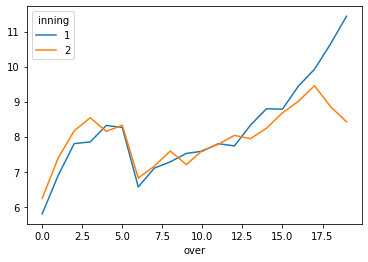

In [56]:
grouped.groupby(['over','inning']).mean()['total_runs'].unstack().plot(kind='line')

In [57]:
sorted_df['ball_innings'] = sorted_df['over'] * 6 + sorted_df['ball']

In [58]:
sorted_df.loc[sorted_df['dismissal_kind'] == 'run out', 'bowler_not_involved'] = 1
sorted_df['bowler_not_involved'] = sorted_df['bowler_not_involved'].fillna(0)
sorted_df['is_bowler_wicket'] = sorted_df['is_wicket'] - sorted_df['bowler_not_involved']

In [59]:
val = sorted_df.groupby(['id','batsman']).agg(match_runs=('batsman_runs', 'sum'), match_balls=('id', 'count'), match_dismissed = ('is_wicket','sum'))

In [60]:
val = val.reset_index()

In [61]:
batsman_statistics = val.groupby('batsman').agg(total_runs = ('match_runs','sum'), total_balls = ('match_balls','sum'), dismissals = ('match_dismissed', 'sum'), innings = ('id', 'count'))

In [62]:
batsman_statistics = batsman_statistics[batsman_statistics['total_balls'] > 100]

In [63]:
batsman_statistics['strike_rate'] = batsman_statistics['total_runs'] / batsman_statistics['total_balls'] * 100
batsman_statistics['average'] = batsman_statistics['total_runs'] / batsman_statistics['innings']

In [64]:
test = batsman_statistics.sort_values(by=['total_runs', 'strike_rate', 'average'], ascending = False).reset_index()

In [65]:
df = pd.DataFrame()

In [66]:
df['batsman'] = test['batsman']
scaler = MinMaxScaler()
df['total_runs'] = list(scaler.fit_transform(test.iloc[:,1:2]).round(3))
df['strike_rate'] = list(scaler.fit_transform(test.iloc[:,5:6]).round(3))
df['average'] = list(scaler.fit_transform(test.iloc[:,6:7]).round(3))

In [67]:
df['avg_3'] = (df['total_runs'] + df['strike_rate'] + df['average']) / 3
df['avg_3'] = df['avg_3'].astype(float)
df['avg_3'] = df['avg_3'].round(2)*100

In [68]:
df.sort_values(by=['avg_3'], ascending = False).to_excel('Batsman Weights.xlsx', index = False)

In [69]:
val = sorted_df.groupby(['id','bowler']).agg(match_runs=('total_runs', 'sum'), match_balls=('id', 'count'), match_dismissed = ('is_bowler_wicket','sum'))

In [70]:
bowler_statistics = val.groupby('bowler').agg(runs_conceeded = ('match_runs','sum'), total_balls = ('match_balls','sum'), dismissals = ('match_dismissed', 'sum'))

In [71]:
bowler_statistics = bowler_statistics.reset_index()

In [72]:
bowler_statistics['runs_per_ball'] = bowler_statistics['runs_conceeded'] / bowler_statistics['total_balls']
bowler_statistics['balls_per_wicket'] = bowler_statistics['total_balls'] / bowler_statistics['dismissals']

In [73]:
bowl_df = pd.DataFrame()

In [74]:
bowler_statistics = bowler_statistics.replace([np.inf, -np.inf], np.nan)

In [75]:
bowler_statistics = bowler_statistics.fillna(10000)

In [76]:
bowler_statistics = bowler_statistics[bowler_statistics['total_balls'] > 0]

In [77]:
bowl_df['bowler'] = bowler_statistics['bowler']
scaler = MinMaxScaler()

In [78]:
bowl_df['dismissals'] = list(scaler.fit_transform(bowler_statistics.iloc[:,3:4]).round(3))
bowl_df['runs_per_ball'] = list(scaler.fit_transform(bowler_statistics.iloc[:,4:5]).round(3))
bowl_df['balls_per_wicket'] = list(scaler.fit_transform(bowler_statistics.iloc[:,5:6]).round(3))

In [79]:
bowl_df['avg_3'] = ((1 - bowl_df['runs_per_ball']) + (1 - bowl_df['balls_per_wicket']) + bowl_df['dismissals']) / 3
bowl_df['avg_3'] = bowl_df['avg_3'].astype(float)
bowl_df['avg_3'] = bowl_df['avg_3'].round(2)*100

In [80]:
bowl_df.sort_values(by=['avg_3'], ascending = False).to_excel('Bowler Weights.xlsx', index = False)

In [81]:
bowl_df = bowl_df.sort_values(by=['avg_3'], ascending = False)

In [83]:
bowl_weights = pd.Series(bowl_df['avg_3'].values, index = bowl_df['bowler']).to_dict()

In [93]:
with open('bowler_weights.pickle', 'wb') as handle:
    pickle.dump(bowl_weights, handle)

In [94]:
batsmen_weights = pd.Series(df['avg_3'].values, index = df['batsman']).to_dict()

In [96]:
with open('batsmen_weights.pickle', 'wb') as handle:
    pickle.dump(batsmen_weights, handle)